In [99]:
from headers import *
from DMP_Segment import *
%matplotlib notebook

In [100]:
class Sequence():

	def __init__(self,meta_force_weights,start_seq,goal_seq,duration):

		self.number_primitives = meta_force_weights.shape[0]
		self.duration = duration
		self.primitives = [DMP(duration) for i in range(self.number_primitives)]

		for i in range(self.number_primitives):
			self.primitives[i].load_weights(meta_force_weights[i])

		self.overlap_fraction = 0.95
		self.overlap = 25		
		self.time_points = npy.zeros(self.number_primitives+1)		

		for i in range(1,self.number_primitives+1):
			self.time_points[i] = self.time_points[i-1]+self.duration-self.overlap
	
		self.time_points = self.time_points.astype(int)			
		self.total_time = self.time_points[-1]
		
		self.roll_pos = npy.zeros((self.total_time,3))
		self.roll_vel = npy.zeros((self.total_time,3))
		self.roll_acc = npy.zeros((self.total_time,3))

		self.start_seq = start_seq
		self.goal_seq = goal_seq

		self.dt = 1.
		self.tau = self.primitives[0].tau
		self.alphaz = self.primitives[0].alphaz
		self.betaz = self.primitives[0].betaz
		self.blend = npy.zeros(self.overlap)

		self.init_vel = npy.zeros(3)		

	def initialize_variables(self):
		self.blend_function()		

	def sigmoid(self,x):
		return 1./(1.+npy.exp(-x))

	def blend_function(self):		
# 		print(self.overlap)
		for i in range(self.overlap):
# 			print(i)
			self.blend[i] = self.sigmoid(0.5*(i-self.overlap/2))

	def calc_rollout_acceleration(self,k,time,forcing_term):        
		self.roll_acc[time] = (1./self.tau**2)*(self.alphaz * (self.betaz * (self.goal_seq[k] - self.roll_pos[time]) - self.tau*self.roll_vel[time]) + forcing_term)
        
	def calc_rollout_vel(self,time):		
		self.roll_vel[time] = self.roll_vel[time-1] + self.roll_acc[time-1]*self.dt

	def calc_rollout_pos(self,time):
		self.roll_pos[time] = self.roll_pos[time-1] + self.roll_vel[time-1]*self.dt

	def initialize_meta_rollout(self):
		self.roll_pos[0] = self.start_seq[0]
		print(self.roll_pos[0])
		self.roll_vel[0] = self.init_vel		

	def meta_rollout(self):
		
		self.initialize_variables()
		self.initialize_meta_rollout()

		force = self.primitives[0].calc_rollout_force_time(0,self.roll_pos[0],self.goal_seq[0])
		self.calc_rollout_acceleration(0,0,force)
		prev_force = npy.zeros(3)
		print(force)
# 		for k in range(self.number_primitives):
		for k in range(1):            
			for t in range(self.time_points[k]+1,self.time_points[k+1]):
				print(k,t)
				prev_force = npy.zeros(3)

				# FORCE BLENDING:
# 				cur_force = self.primitives[k-1].calc_rollout_force_time(t-self.time_points[k],self.roll_pos[self.time_points[k]],self.goal_seq[k])	
				cur_force = self.primitives[k].calc_rollout_force_time(t-self.time_points[k],self.roll_pos[self.time_points[k]],self.goal_seq[k])	                
				
				if (k and ((t-self.time_points[k])<self.overlap)):
					
					prev_force = self.primitives[k-1].calc_rollout_force_time(t-self.time_points[k-1],self.roll_pos[self.time_points[k-1]],self.goal_seq[k-1])					
                    
					print("BLEND VALUE: ",self.blend[min(self.overlap-1,t-self.time_points[k])])                    
					force = (1-self.blend[min(self.overlap-1,t-self.time_points[k])])*prev_force + self.blend[min(self.overlap-1,t-self.time_points[k])]*cur_force
				else: 
# 					print("Not blending")
					force = copy.deepcopy(cur_force)
				print(force)                    
				self.calc_rollout_vel(t)
				self.calc_rollout_pos(t)
				self.calc_rollout_acceleration(k,t,force)

#     def meta_rollout_again(self):
        
#         self.initialize_variables()
#         self.initialize_meta_rollout()
        
#         force = self.primitives[0].calc_rollout_force_time(0,self.roll_pos[0],self.goal_seq[0])
#         self.calc_rollout_acceleration(0,0,force)            
#         prev_force = npy.zeros(3)
        
#         for k in range(1):
#             for t in range(self.time_points[k],self.time_points[k+1]):
                
        
                
                
	def save_rollout(self):

		with file('roll_pos.npy','w') as outfile:
			npy.save(outfile,self.roll_pos)

		with file('roll_vel.npy','w') as outfile:
			npy.save(outfile,self.roll_vel)

		with file('roll_acc.npy','w') as outfile:
			npy.save(outfile,self.roll_acc)


In [101]:
cd ../../Data/Cornell_Data/Primitive_Library/Subject1/Traj_0/Interp_Segment_All

[Errno 2] No such file or directory: '../../Data/Cornell_Data/Primitive_Library/Subject1/Traj_0/Interp_Segment_All'
/home/tanmay/Research/Code/ActionPrimitives/Data/Cornell_Data/Primitive_Library/Subject1/Traj_0


In [111]:
cd Interp_Segment_All/

/home/tanmay/Research/Code/ActionPrimitives/Data/Cornell_Data/Primitive_Library/Subject1/Traj_0/Interp_Segment_All


In [112]:
meta_fw = npy.load("LH_Primitive_Weights.npy")
start_seq = npy.load("LH_Start_Seq.npy")
goal_seq = npy.load("LH_Goal_Seq.npy")
seq = Sequence(meta_fw,start_seq,goal_seq,500)

In [113]:
seq.blend_function()

In [114]:
cd ..

/home/tanmay/Research/Code/ActionPrimitives/Data/Cornell_Data/Primitive_Library/Subject1/Traj_0


In [115]:
pos = npy.load("lh_comp_pos_0.npy")
vel = npy.load("lh_comp_vel_0.npy")
seq.init_vel = vel[0,:3]
pos.shape
pos1 = npy.load("Interp_Segment_All/LH_Segment_0/interp_demo_pos.npy")
pos2 = npy.load("Interp_Segment_All/LH_Segment_1/interp_demo_pos.npy")

In [117]:
seq.initialize_variables()
seq.initialize_meta_rollout()
# seq.meta_rollout()

[ -10.8 -488.1   13.5]


In [118]:
seq.roll_pos[0],seq.roll_vel[0],seq.goal_seq[0]

(array([ -10.8, -488.1,   13.5]),
 array([-0.5,  2.1, -1.3]),
 array([ 157.5, -262.6,  343.5]))

In [120]:
print(seq.primitives[0].calc_rollout_force_time(0,seq.roll_pos[0],seq.goal_seq[0]))

[ -1276187.34750539   1741428.87753822 -10291008.3505876 ]


<IPython.core.display.Javascript object>


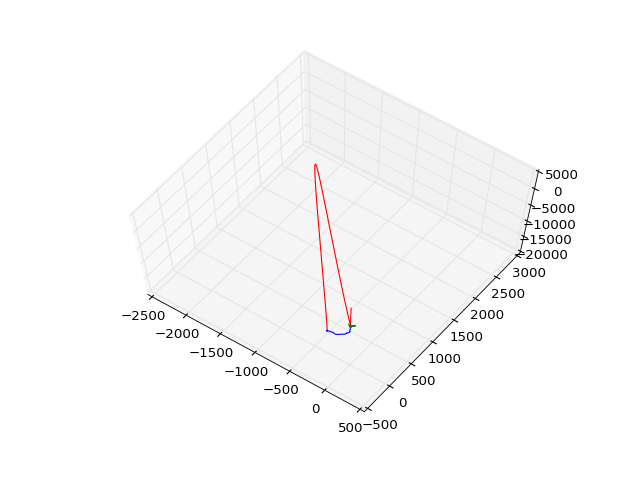

In [61]:
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.plot(seq.roll_pos[:450,0],seq.roll_pos[:450,1],seq.roll_pos[:450,2],'r')
ax.plot(seq.roll_pos[:950,0],seq.roll_pos[:950,1],seq.roll_pos[:950,2],'r')
ax.plot(pos1[:,0],pos1[:,1],pos1[:,2],'b')
ax.plot(pos2[:,0],pos2[:,1],pos2[:,2],'g')
plt.show()

In [62]:
# seq.primitives[0].weights
seq.roll_pos[450:500]

array([[ 142.71703322, -245.42661619,  261.65357909],
       [ 142.96035559, -245.7123222 ,  263.04285378],
       [ 143.1996979 , -245.99329119,  264.40851439],
       [ 143.43512451, -246.26960107,  265.75096115],
       [ 143.66669875, -246.54132846,  267.07058761],
       [ 143.89448294, -246.80854877,  268.36778068],
       [ 144.11853843, -247.07133618,  269.6429208 ],
       [ 144.33892559, -247.32976365,  270.89638201],
       [ 144.55570384, -247.58390299,  272.12853209],
       [ 144.76893163, -247.83382482,  273.33973263],
       [ 144.97866651, -248.07959863,  274.53033912],
       [ 145.1849651 , -248.32129278,  275.70070112],
       [ 145.38788313, -248.55897452,  276.85116227],
       [ 145.58747544, -248.79271   ,  277.98206044],
       [ 145.78379599, -249.02256431,  279.09372782],
       [ 145.97689788, -249.24860146,  280.186491  ],
       [ 146.16683337, -249.47088445,  281.26067107],
       [ 146.35365389, -249.68947522,  282.3165837 ],
       [ 146.53741004, -249.

In [52]:
seq.goal_seq

array([[ 157.5, -262.6,  343.5],
       [ 122.4, -248.2,  256.8],
       [  34.9, -171.5,  342.9],
       [  -0.8, -504.3,    0. ],
       [ 221.1,  -89.8,  458.3],
       [ 121.8, -309.3,  380.8],
       [ -66. , -292.8,  274.1],
       [ -26.1, -489.4,    4.1]])